# Exploración de Datos

En este notebook vamos a hacer una primera aproximación al set de imágenes, mediante un análisis exploratorio


In [2]:
import numpy as np
import cv2
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def get_labels_and_paths(input_folder):
   return sorted([(dp.split("/")[1],os.path.join(dp, f)) for dp, dn, filenames in os.walk('input') for f in filenames if os.path.splitext(f)[1] == '.jpg'])

def img_to_numpy(path): 
    img = cv2.imread(filename=path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def tomar_muestra(label_names, muestra=4):
    N = label_names.name.nunique()
    M = muestra
    sample = (label_names.groupby('label')
                      .sample(n=M, replace=False)
                      .reset_index(drop=True)[['file', 'name']]
                      .set_index('file')
                      .to_records()
                      .reshape(N, M)
                      )
    return sample

def muestreo_categorias(label_names, muestra=4,save_path=None):
    N = label_names.name.nunique()
    M = muestra
    flowers_sample = tomar_muestra(label_names=label_names, muestra=M)

    fig, axs = plt.subplots(ncols=M, nrows=N, figsize=(M*4, N*4))
    for i in range(N):
        for j in range(M):
            x = flowers_sample[i, j]
            path = x['file']
            name = x['name']
            img = cv2.imread(filename=path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[i, j].imshow(img)
            axs[i, j].set_title(name)
            axs[i, j].axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close(fig)
    return None

In [4]:
INPUT_FOLDER = "input/"
labels_and_paths = get_labels_and_paths(input_folder=INPUT_FOLDER)
input_paths = [x[1] for x in labels_and_paths]

label_names = pd.DataFrame(labels_and_paths, columns=["name","file"])
label_names['label'] = label_names['name'].map({"Arborio":0,
                                                "Basmati":1,
                                                "Ipsala":2,
                                                "Jasmine":3,
                                                "Karacadag":4})

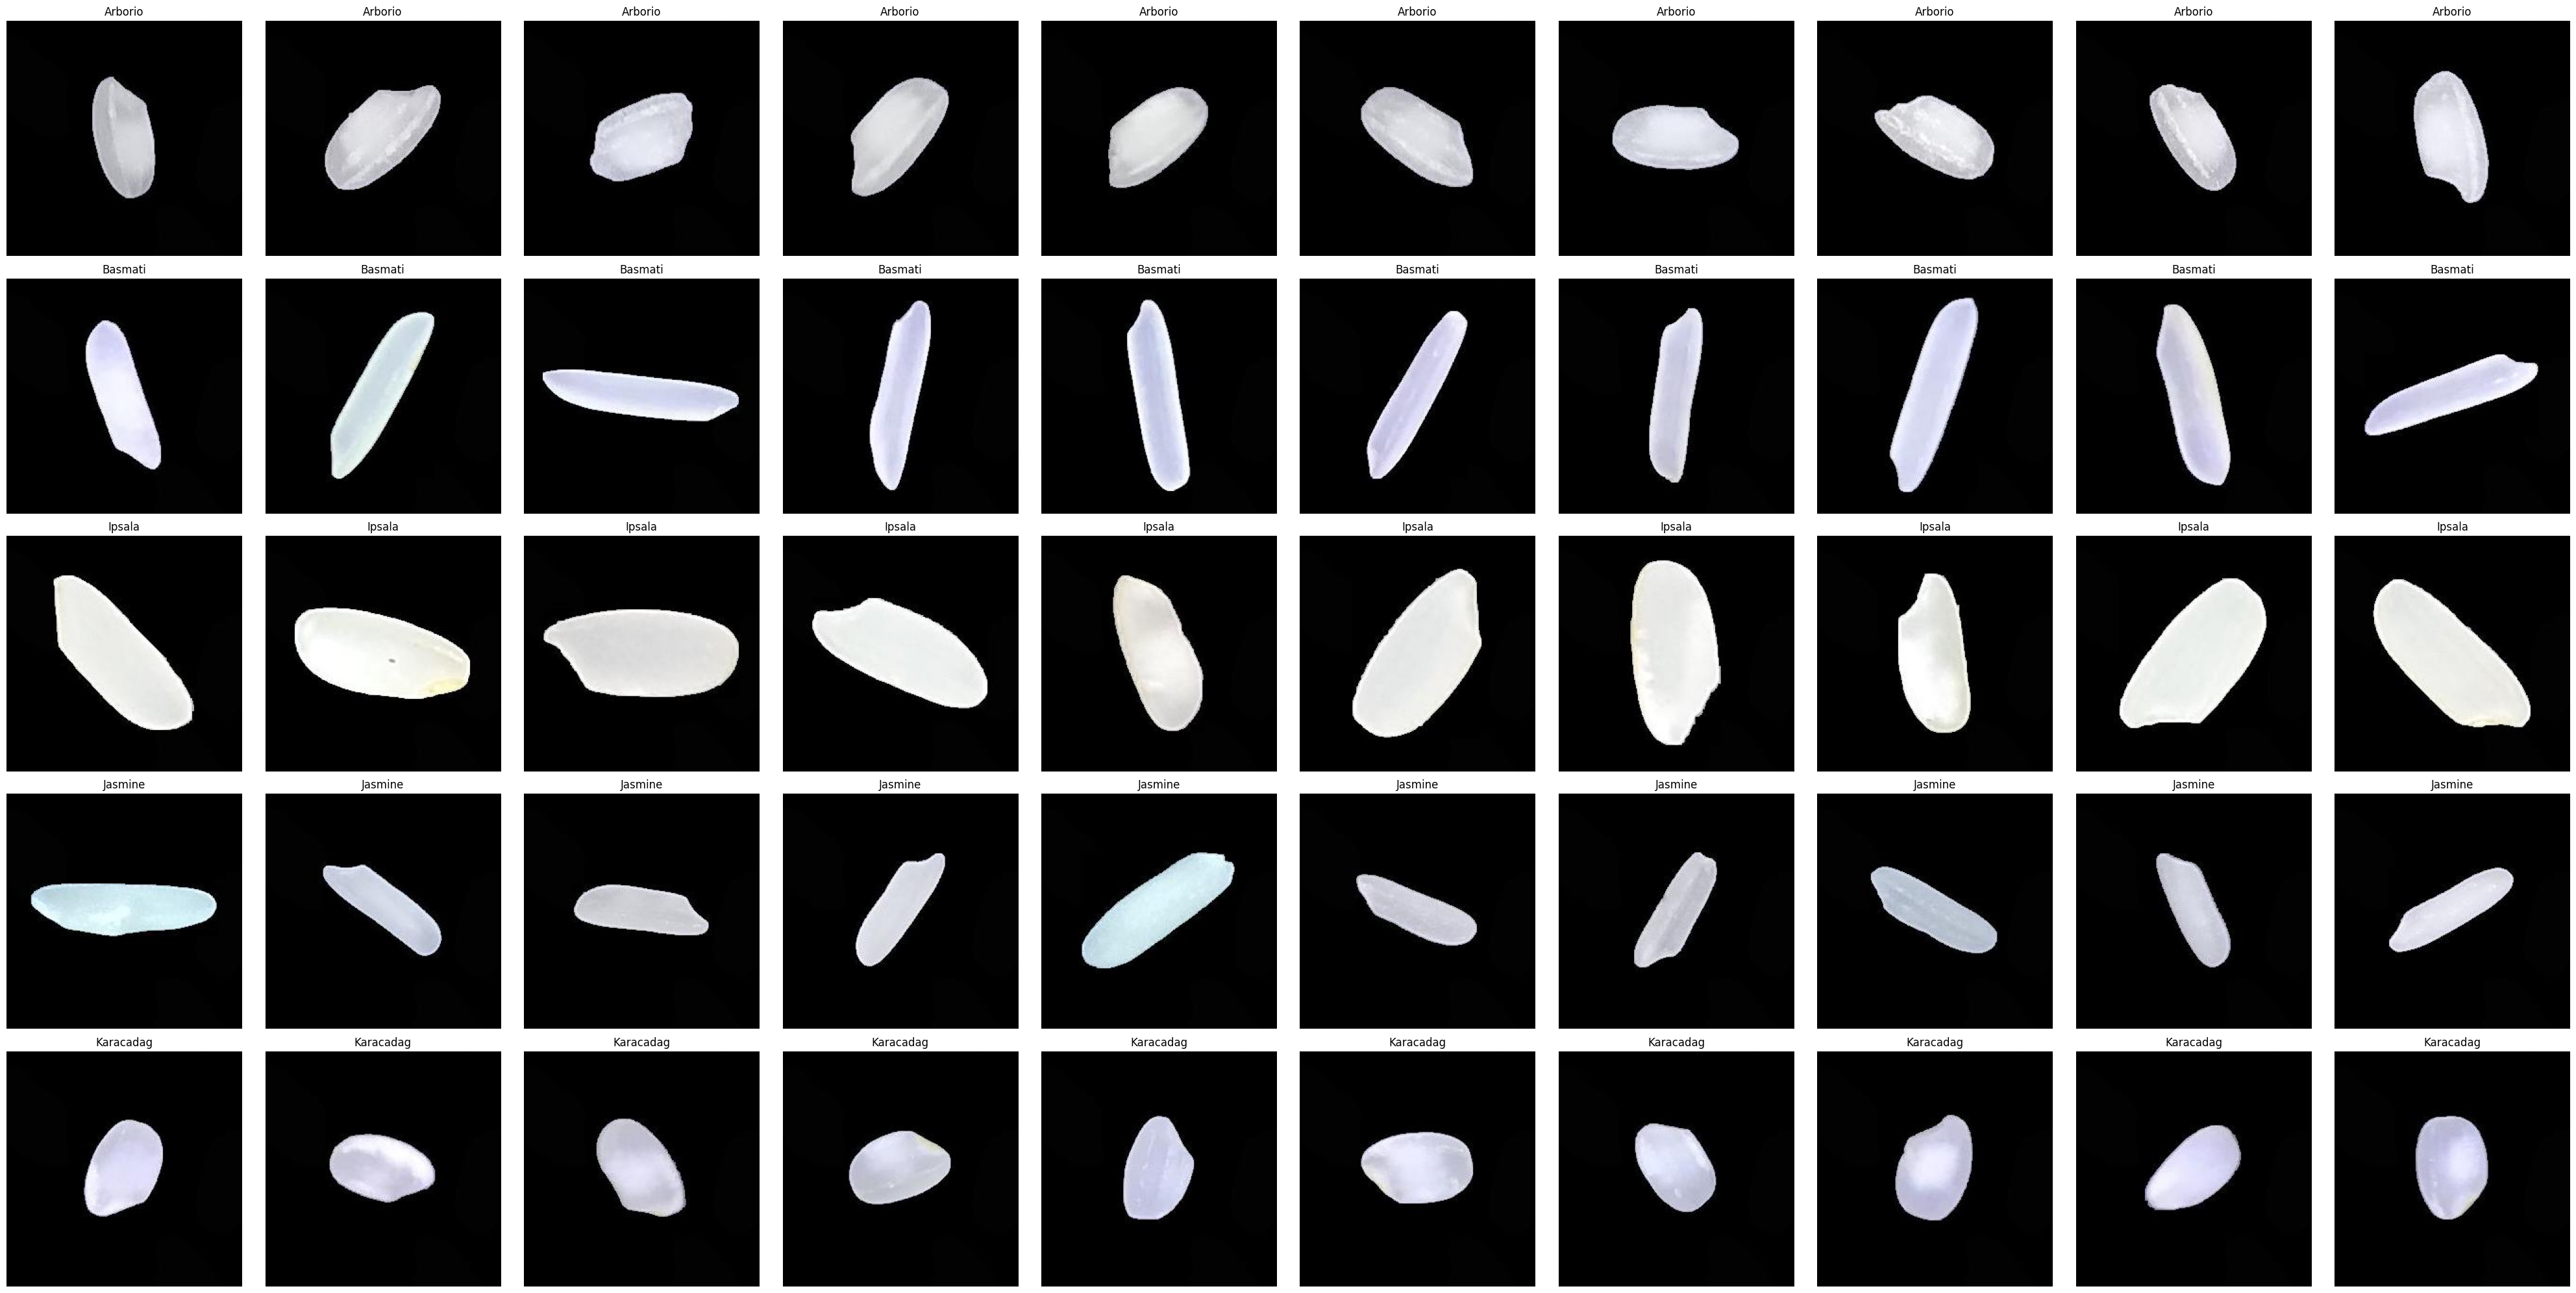

In [5]:
muestreo_categorias(label_names=label_names, muestra=10)

In [9]:
import seaborn as sns
k = 0.8  # proporción del radio máximo (250/2) que me quiero quedar 
lx, ly = 250,250
X, Y = np.ogrid[0:lx, 0:ly]
mask_interno = (X - lx/2)**2 + (Y - ly/2)**2 < ((k)**2)*(lx*ly/4) #devuelve True para los píxeles internos del círculo
mask_externo = (X - lx/2)**2 + (Y - ly/2)**2 > ((k)**2)*(lx*ly/4) #devuelve True para los píxeles externos del círculo

#sacamos la imagen de 208x208
dicc = label_names.groupby('name')['file'].unique().to_dict()

max_pics = 15

por_clase = {}
for k in dicc.keys(): 
    compilar = np.empty((250*250, 3), dtype=np.uint8)
    for n,p in enumerate(dicc[k]):
        if n==max_pics:
            break
        else:
            img = img_to_numpy(path=p)[mask_interno].reshape((-1, 3)) #la función los lee RGB y no GBR
            compilar = np.concatenate((compilar, img), axis=0)
    por_clase[k] = compilar


/home/nachengue/fundar/python_projects/unsupervised-rice-image-segmentation/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nachengue/fundar/python_projects/unsupervised-rice-image-segmentation/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nachengue/fundar/python_projects/unsupervised-rice-image-segmentation/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nachengue/fu

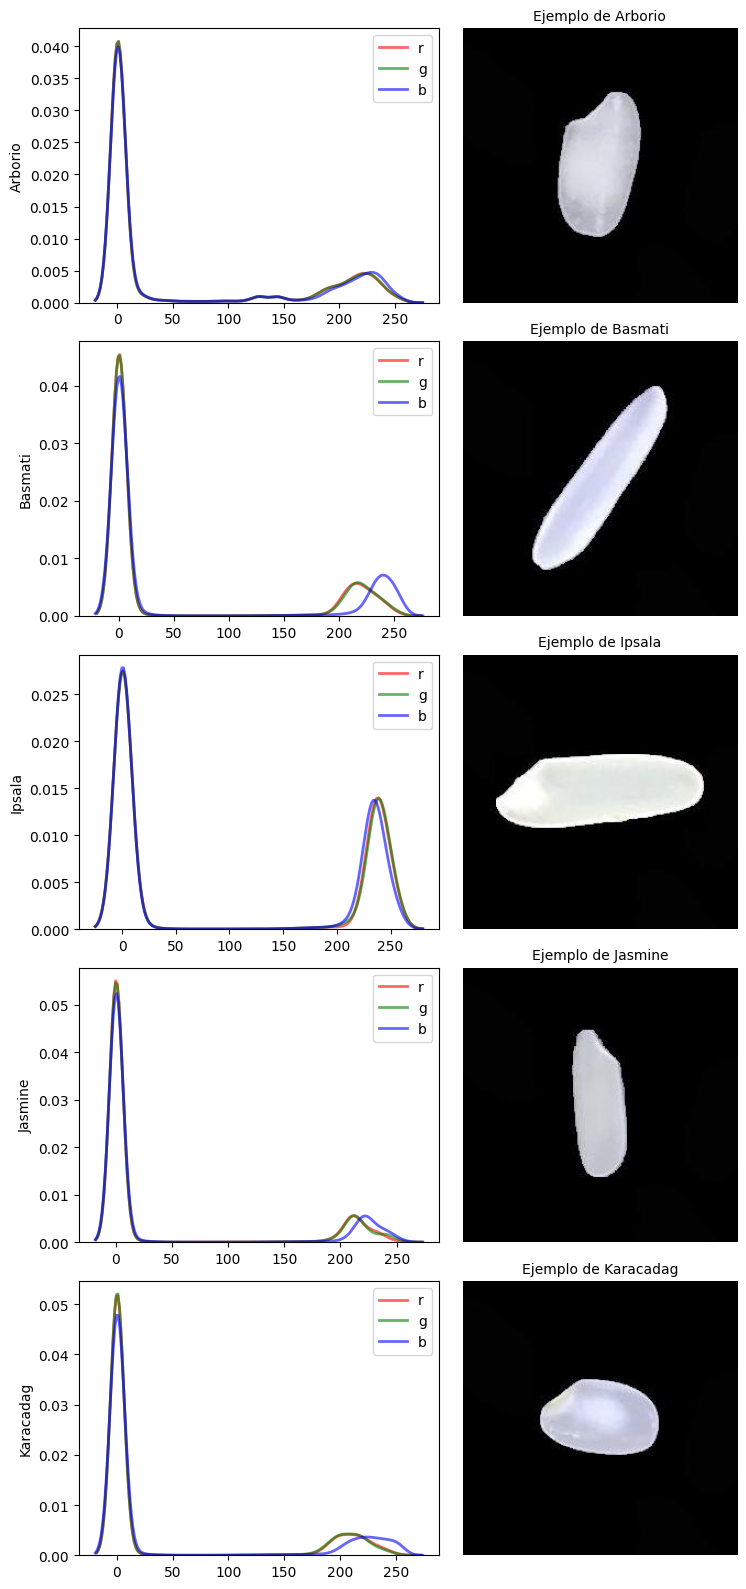

In [11]:
# Genero gráfico de arroces

clases_archivo = [i[0] for i in tomar_muestra(label_names=label_names, muestra=1)]
fig, axs = plt.subplots(nrows=len(clases_archivo),ncols=2, figsize=(8,16), constrained_layout=True) 

for i,x in enumerate(clases_archivo): 
    f,c = x[0],x[1]
    for j in range(3):
        sns.kdeplot(por_clase[c][:,j], color="rgb"[j], label="rgb"[j], alpha=0.6, ax=axs[i][0], linewidth=2)
        # axs[i][0].hist(por_clase[c][:,j],  bins=range(0, 255 + 10, 10), color="rgb"[j], edgecolor='k', alpha=0.3, label="rgb"[j], density=True)
        #[i][0].set_ylim(0,0.025)
        axs[i][0].legend()
        axs[i][0].set_ylabel(c, )
    img = img_to_numpy(f)
    #img[mask_externo]=255
    axs[i][1].imshow(img)
    axs[i][1].axis('off')
    axs[i][1].set_title(f"Ejemplo de {c}", fontsize=10)
    
plt.tight_layout()
plt.show()  

In [10]:
names_and_paths = get_labels_and_paths(input_folder='input')

import random
from collections import Counter
from itertools import groupby

# Contar las clases
class_counts = Counter(item[0] for item in names_and_paths)

# Calcular la cantidad mínima de elementos por clase
min_count = 100

# Crear una lista de elementos por clase
grouped_data = {key: [item for item in names_and_paths if item[0] == key] for key in class_counts.keys()}

# Tomar una muestra estratificada
stratified_sample = []
for key, group in grouped_data.items():
    random.shuffle(group)  # Mezcla los elementos para obtener una muestra aleatoria
    stratified_sample.extend(group[:min_count])  # Agrega la misma cantidad de elementos por clase